In [1]:
%load_ext autoreload
import torch

import sys

sys.path.append("../..")
from mlstm_kernels.utils.test.checks import verify_output
from mlstm_kernels.torch.utils import to_numpy
from tests.torch.losses_tests import loss_layernorm_offset_quadratic

torch.set_printoptions(linewidth=200)

In [2]:
%autoreload 2
from mlstm_kernels.torch.parallel.native_stablef import (
    mlstm_parallel__native_stablef_autograd,
)
from mlstm_kernels.torch.chunkwise.native import mlstm_chunkwise__native_custbw
from mlstm_kernels.torch.chunkwise.native.bw import (
    mlstm_chunkwise__recurrent_bw_dC as mlstm_cw_rec_bw_dC_native,
)
from mlstm_kernels.torch.chunkwise.triton_xl_chunk import mlstm_chunkwise__xl_chunk
from mlstm_kernels.torch.chunkwise.triton_xl_chunk.bw_recurrent import (
    mlstm_chunkwise__recurrent_bw_dC as mlstm_cw_rec_bw_dC_xl_chunk,
)

In [3]:
seed = 1
B = 1
NH = 1
S = 1024
DHQK = 32
DHHV = 32
device = torch.device("cuda:0")
dtype = torch.float32

vecI_offset = 0.0
vecF_offset = 3.0

In [4]:
torch.manual_seed(seed)
matQ = torch.randn((B, NH, S, DHQK), dtype=torch.float32, device=device)
matK = torch.randn((B, NH, S, DHQK), dtype=torch.float32, device=device)
matV = torch.randn((B, NH, S, DHHV), dtype=torch.float32, device=device)
vecI = vecI_offset + torch.randn((B, NH, S), dtype=torch.float32, device=device)
vecF = vecF_offset + torch.randn((B, NH, S), dtype=torch.float32, device=device)

baseline_dtype = dtype
matQ_baseline = matQ.clone().to(dtype=baseline_dtype).detach().requires_grad_(True)
matK_baseline = matK.clone().to(dtype=baseline_dtype).detach().requires_grad_(True)
matV_baseline = matV.clone().to(dtype=baseline_dtype).detach().requires_grad_(True)
vecI_baseline = vecI.clone().to(dtype=baseline_dtype).detach().requires_grad_(True)
vecF_baseline = vecF.clone().to(dtype=baseline_dtype).detach().requires_grad_(True)

target_dtype = dtype
matQ_target = matQ.clone().to(dtype=target_dtype).detach().requires_grad_(True)
matK_target = matK.clone().to(dtype=target_dtype).detach().requires_grad_(True)
matV_target = matV.clone().to(dtype=target_dtype).detach().requires_grad_(True)
vecI_target = vecI.clone().to(dtype=target_dtype).detach().requires_grad_(True)
vecF_target = vecF.clone().to(dtype=target_dtype).detach().requires_grad_(True)

In [5]:
for cs in [64, 128, 256, 512, 1024]:
    matH_bl, _ = mlstm_chunkwise__native_custbw(
        matQ_baseline,
        matK_baseline,
        matV_baseline,
        vecI_baseline,
        vecF_baseline,
        return_last_states=True,
        chunk_size=cs,
    )
    loss_layernorm_offset_quadratic(matH_bl).backward()

Saved inputs to /home/max/myrepos/nxai_public/mlstm_kernels_internal_cleaned/notebooks_kernel_dev/xl_chunk/debug_xl_chunk_bw_dC_inputs_cs64.pt
Saved inputs to /home/max/myrepos/nxai_public/mlstm_kernels_internal_cleaned/notebooks_kernel_dev/xl_chunk/debug_xl_chunk_bw_dC_inputs_cs128.pt
Saved inputs to /home/max/myrepos/nxai_public/mlstm_kernels_internal_cleaned/notebooks_kernel_dev/xl_chunk/debug_xl_chunk_bw_dC_inputs_cs256.pt
Saved inputs to /home/max/myrepos/nxai_public/mlstm_kernels_internal_cleaned/notebooks_kernel_dev/xl_chunk/debug_xl_chunk_bw_dC_inputs_cs512.pt
Saved inputs to /home/max/myrepos/nxai_public/mlstm_kernels_internal_cleaned/notebooks_kernel_dev/xl_chunk/debug_xl_chunk_bw_dC_inputs_cs1024.pt


In [25]:
inputs = torch.load("debug_xl_chunk_bw_dC_inputs_cs256.pt")

/tmp/ipykernel_90905/1066544520.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inputs = torch.load("debug_xl_chunk_bw_dC_inputs_cs256.pt")


In [26]:
mQ_bl = inputs["matQ"]
vB_bl = inputs["vecB"]
vF_bl = inputs["vecF"]
sM_bl = inputs["scaM_inter"]
vMc_bl = inputs["vecM_combine"]
mDH_bl = inputs["matDeltaH"]
vNo_bl = inputs["vecN_out"]
mDCl_bl = inputs["matDeltaC_last"]
num_chunks = inputs["NUM_CHUNKS"]
eps = inputs["EPS"]
chunk_size = inputs["CHUNK_SIZE"]
print(f"chunk_size: {chunk_size}, num_chunks: {num_chunks}, eps: {eps}")
print(
    f"matQ shape: {mQ_bl.shape}, vecB shape: {vB_bl.shape}, vecF shape: {vF_bl.shape}, sM shape: {sM_bl.shape}, vMc shape: {vMc_bl.shape}, mDH shape: {mDH_bl.shape}, vNo shape: {vNo_bl.shape}, mDCl shape: {mDCl_bl.shape}"
)
matDeltaC_states_gt = inputs["matDeltaC_states"]

mDC_comp_bl = mlstm_cw_rec_bw_dC_native(
    matQ=mQ_bl,
    vecB=vB_bl,
    scaM_inter=sM_bl,
    vecM_combine=vMc_bl,
    matDeltaH=mDH_bl,
    vecN_out=vNo_bl,
    matDeltaC_last=mDCl_bl,
    qk_scale=None,
    num_chunks=num_chunks,
    eps=eps,
    chunk_size=chunk_size,
)

chunk_size: 256, num_chunks: 4, eps: 9.999999974752427e-07
matQ shape: torch.Size([1, 1, 1024, 32]), vecB shape: torch.Size([1, 1, 4, 256]), vecF shape: torch.Size([1, 1, 4, 256]), sM shape: torch.Size([1, 1, 5]), vMc shape: torch.Size([1, 1, 1024]), mDH shape: torch.Size([1, 1, 1024, 32]), vNo shape: torch.Size([1, 1, 1024]), mDCl shape: torch.Size([1, 1, 32, 32])


In [37]:
mdC_comp_tgt = mlstm_cw_rec_bw_dC_xl_chunk(
    matQ=mQ_bl,
    vecF=vF_bl,
    scaM_inter=sM_bl,
    vecM_combine=vMc_bl,
    matDeltaH=mDH_bl,
    vecN_out=vNo_bl,
    matDeltaC_last=mDCl_bl,
    qk_scale=None,
    chunk_size=128,  # chunk_size,
    save_states_every_nth_chunk=2,  # 1,
    eps=eps,
)

In [38]:
mDC_comp_bl, mDC_comp_bl.shape

(tensor([[[[  0.5165,   0.6941,   1.6069,  ...,   0.6565,  -1.5355,   0.2573],
           [ -6.6608,  -2.8711, -18.4791,  ...,  -6.8850,   9.4759,  -1.8189],
           [  0.3592,  -0.0368,   0.7500,  ...,   0.4058,  -0.1226,  -0.0767],
           ...,
           [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
           [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
           [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]]]], device='cuda:0', grad_fn=<CopySlices>),
 torch.Size([1, 1, 160, 32]))

In [39]:
mdC_comp_tgt, mdC_comp_tgt.shape

(tensor([[[[  0.5164,   0.6937,   1.6061,  ...,   0.6560,  -1.5346,   0.2572],
           [ -6.6584,  -2.8688, -18.4698,  ...,  -6.8806,   9.4716,  -1.8179],
           [  0.3590,  -0.0368,   0.7496,  ...,   0.4055,  -0.1226,  -0.0766],
           ...,
           [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
           [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
           [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]]]], device='cuda:0'),
 torch.Size([1, 1, 160, 32]))

                 mdC|NAtype| diff: p50 : 9.29875e-03|p90 : 3.00138e-01 | maxreldiff:        1.3109643954984849 | maxdiff:         1.657872200012207 | meandiff:       0.09186143335817434 | allclose(atol=1e-05,rtol=1e-05): False | max abs bl: 18.479130 | max abs tg: 18.47


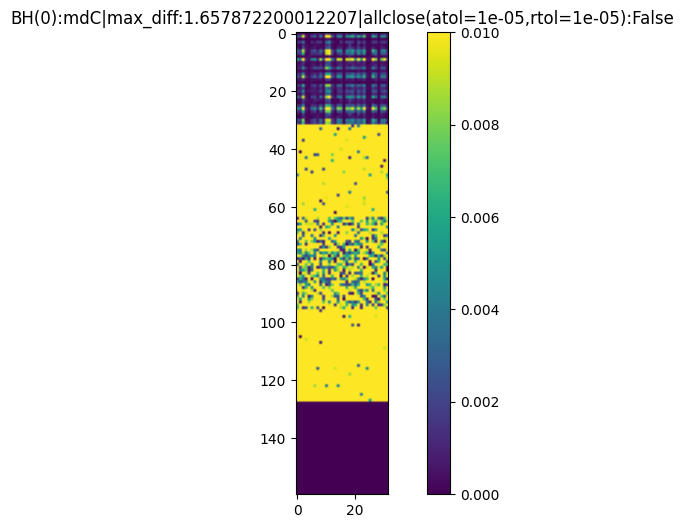

In [40]:
fig = verify_output(
    "mdC", to_numpy(mDC_comp_bl), to_numpy(mdC_comp_tgt), atol=1e-5, rtol=1e-5
)

In [5]:
matH_bl = mlstm_parallel__native_stablef_autograd(
    matQ_baseline,
    matK_baseline,
    matV_baseline,
    vecI_baseline,
    vecF_baseline,
    stable_fgate=True,
    normalize=True,
)
loss_layernorm_offset_quadratic(matH_bl).backward()

In [6]:
matH_tgt = mlstm_chunkwise__xl_chunk(
    matQ_target, matK_target, matV_target, vecI_target, vecF_target, chunk_size=128
)
loss_layernorm_offset_quadratic(matH_tgt).backward()

In [ ]:
fig = verify_output("matH", to_numpy(matH_bl), to_numpy(matH_tgt), atol=1e-5, rtol=1e-5)

In [ ]:
fig = verify_output(
    "matQ.grad",
    to_numpy(matQ_baseline.grad),
    to_numpy(matQ_target.grad),
    atol=1e-5,
    rtol=1e-5,
)

In [ ]:
fig = verify_output(
    "matK.grad",
    to_numpy(matK_baseline.grad),
    to_numpy(matK_target.grad),
    atol=1e-5,
    rtol=1e-5,
)

In [ ]:
fig = verify_output(
    "matV.grad",
    to_numpy(matV_baseline.grad),
    to_numpy(matV_target.grad),
    atol=1e-5,
    rtol=1e-5,
)

In [ ]:
fig = verify_output(
    "vecI.grad",
    to_numpy(vecI_baseline.grad),
    to_numpy(vecI_target.grad),
    atol=1e-5,
    rtol=1e-5,
)

In [ ]:
fig = verify_output(
    "vecF.grad",
    to_numpy(vecF_baseline.grad),
    to_numpy(vecF_target.grad),
    atol=1e-5,
    rtol=1e-5,
)